In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import emcee
import time
import aesara
import timeit

starry.config.quiet = True
np.random.seed(1)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [2]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [26]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    # y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y


    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm)
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    med_flux = np.median(flux)
    flux /= med_flux
    err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux, mu_flux

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [27]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

Solving for mean and covariance of $f_{obs}$
$$m=1/\alpha$$
$$f_{obs} = f_{true}{\alpha}+\epsilon$$
$$f_{true} \sim \mathcal{N}(\mu,\Sigma)$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$
$$f_{obs} \sim \mathcal{N}(\frac{\mu}{m},\frac{\Sigma}{m^2}+\sigma^2I)$$
Now, I need to change $\Sigma$:
$$\tilde\Sigma^{-1} = (\frac{1}{m^2}\Sigma)^{-1} = m^2\Sigma^{-1}$$
$$\tilde Q = m^2 Q$$
$$ln\vert\tilde\Sigma\vert = ln\vert\frac{1}{m^2}\Sigma\vert = ln((\frac{1}{m^2})^n\vert\Sigma\vert) = -2n ln(m)+ ln\vert\Sigma\vert$$

In [28]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            # sigma=sigma,
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")
        
        A = A / norm
        
        '''
        # Compute the flux covariance
        cov_ylm = sp.cov_ylm
        cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
        cov_flux += tt.diag(err) ** 2

        # Compute the flux mean; remember to offset Y_{0,0} by one
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) / norm

        # Marginal likelihood
        pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux)
        '''
        Sigma_s = sp.cov_ylm 
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) #/ norm
        K = len(t)

        U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

        log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
        # log_sigmadet -= 2*256*tt.log(norm)

        r = tt.as_tensor_variable(flux) - mu_flux
        v = tt.dot(A.T,(r/tt.square(err)))
        Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

        loglike = -0.5 * Q
        loglike -= 0.5  * log_sigmadet
        loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        
        return model

## Generate a light curve

(721, 256)


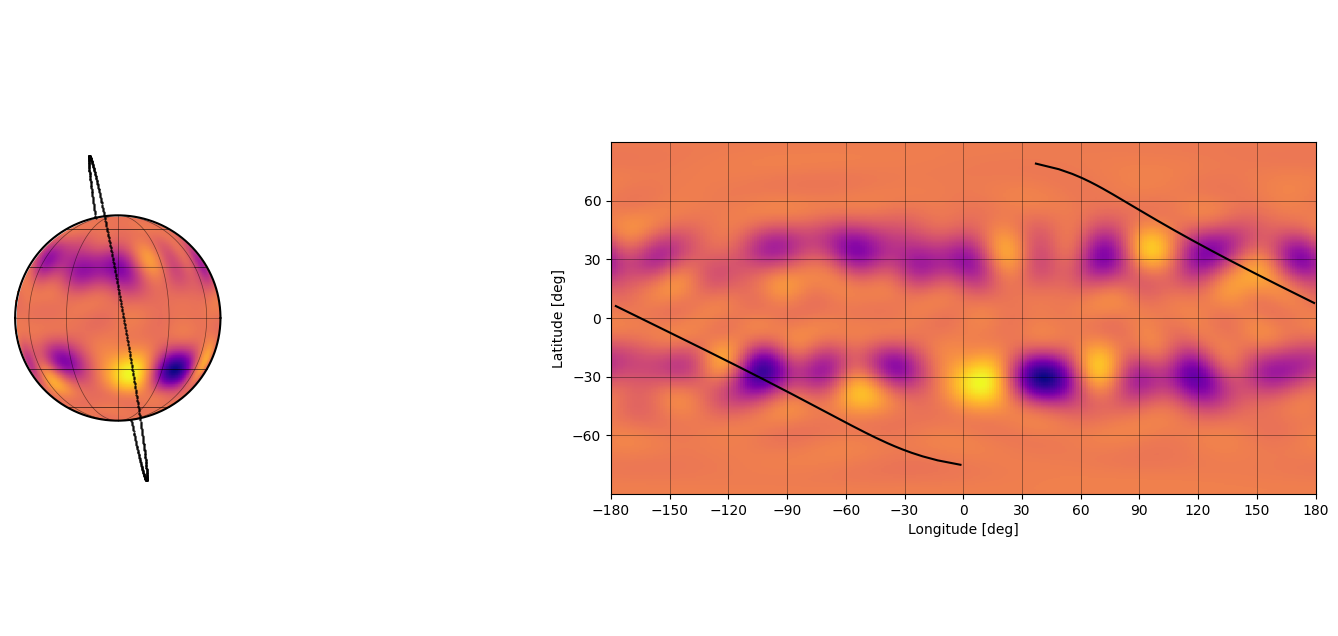

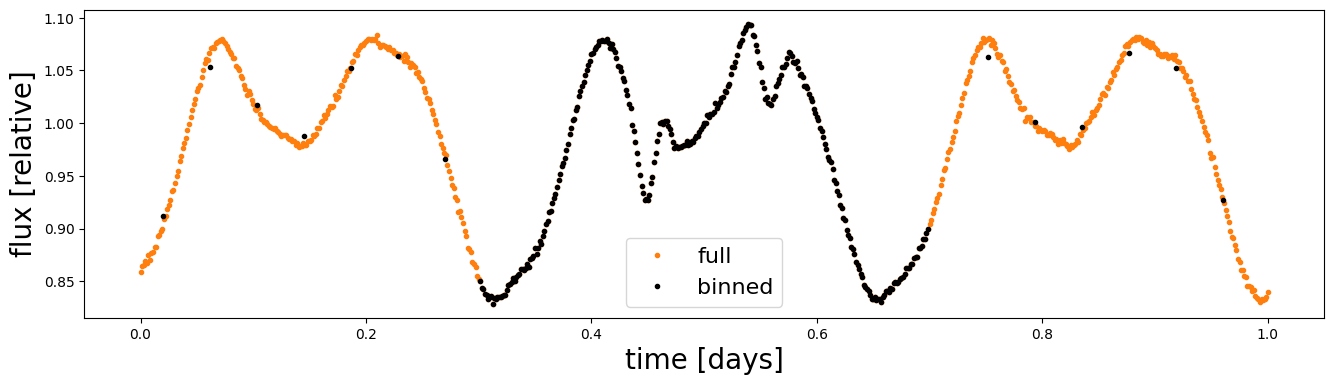

In [29]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Angle},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux, mu_flux = generate(t, params, error=1e-4)

# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=1, label="full")
ax.plot(t_, flux_, "k.", label="binned")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [7]:
params['gp.norm']['truth'] = med_flux

In [8]:
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]

In [9]:
starry.config.lazy = True

In [10]:
# Instantiate the system
map = starry.Map(15, 2)
map.inc = parameter("star.inc")
map[1] = parameter("star.u1")
map[2] = parameter("star.u2")
star = starry.Primary(map, m=parameter("star.m")) 
planet = starry.Secondary(
    starry.Map(),
    inc=parameter("planet.inc"),
    ecc=parameter("planet.ecc"),
    Omega=parameter("planet.Omega"),
    w=parameter("planet.w"),
    porb=parameter("planet.porb"),
    t0=parameter("planet.t0"),
)
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)

In [11]:
# Get the flux design matrix
theta = (360 * t / parameter("star.prot")) % 360
A = map.design_matrix(
    theta=theta,
    xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
    yo=yo[1],
    zo=zo[1],
    ro=parameter("planet.r"),
).eval()

In [12]:
A.shape

(721, 256)

In [13]:
A[0,3]

0.0

In [23]:
A[:,0]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [14]:
np.nonzero(A==0)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  1,   3,   4,   7,  10,  13,  15,  16,  18,  21,  23,  26,  28,
         31,  33,  35,  36,  38,  40,  43,  45,  47,  50,  52,  54,  57,
         59,  61,  63,  64,  66,  68,  70,  73,  75,  77,  79,  82,  84,
         86,  88,  91,  93,  95,  97,  99, 100, 102, 104, 106, 108, 111,
        113, 115, 117, 119, 122, 124, 126, 128, 130, 133, 135, 137, 139,
        141, 143, 144, 146, 148, 150, 152, 154, 157, 159, 161, 163, 165,
        167, 170, 172, 174, 176, 178, 180, 183, 185, 187, 189, 191, 193,
        195, 196, 198, 200, 202, 204, 206, 208, 211, 213, 215, 217, 219,
   

In [15]:
sp = StarryProcess(
    mu=params['gp.mu']['truth'],
    sigma=params['gp.sigma']['truth'],
    r=params['gp.r']['truth'],
    c=params['gp.c']['truth'],
    n=params['gp.n']['truth'],
    marginalize_over_inclination=False,  # *** we know the inclination
    normalized=False,  # *** we're modeling the normalization explicitly
)
Sigma_s = sp.cov_ylm
mu_ylm = sp.mean_ylm
mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
mu_flux = tt.dot(A, mu_ylm).eval() #/ norm
K = len(t)

U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
# log_sigmadet -= 2*256*tt.log(norm)

r = tt.as_tensor_variable(flux) - mu_flux
v = tt.dot(A.T,(r/tt.square(err)))
Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

loglike = -0.5 * Q
loglike -= 0.5  * log_sigmadet
loglike -= 0.5 * K * tt.log(2 * np.pi)

In [16]:
mu_ylm.eval()

array([ 9.53016873e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.75584264e-03,  0.00000000e+00,
       -9.96941189e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.27461026e-02,  0.00000000e+00,  1.90007680e-02,  0.00000000e+00,
        2.51356534e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.36470955e-18,  0.00000000e+00,
       -2.30258034e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.08751959e-02,  0.00000000e+00,
        1.57596562e-02,  0.00000000e+00,  1.72638384e-02,  0.00000000e+00,
        2.33753476e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [17]:
y = sp.sample_ylm().eval().reshape(-1)

In [18]:
y

array([-4.69811451e-02, -1.34934830e-03,  3.37653430e-03,  5.86044156e-04,
        6.72381477e-03, -1.06636514e-02, -2.19593546e-03,  4.75128470e-03,
       -1.17054175e-02,  8.07917894e-03,  4.82279416e-03, -8.56127542e-03,
        1.92360462e-03, -8.92791778e-04, -4.49466224e-03,  1.88018667e-03,
       -5.56233842e-03, -3.93591365e-03,  1.10688351e-02, -4.43554743e-03,
        9.90990845e-03,  1.98611192e-04,  1.34117140e-02, -4.49124695e-03,
        2.95761089e-02,  4.78730745e-03, -7.08122926e-03,  7.40449006e-03,
        8.73654357e-04, -4.62497162e-03,  6.32963764e-03,  9.39906423e-03,
       -1.35747477e-02,  1.15100751e-03,  2.76279772e-03, -2.03039435e-03,
       -1.03736792e-02, -1.71216568e-03,  4.92065340e-04,  1.57549127e-02,
       -1.95938829e-03, -1.22623070e-02,  3.20445127e-03, -3.68895768e-04,
        1.21787816e-02, -6.83287545e-03,  2.21279453e-02,  4.59394279e-04,
        2.27389478e-02, -8.27480441e-04, -9.05849527e-03, -5.07947953e-03,
        1.88249622e-03,  

In [24]:
mu_ylm.eval()

array([ 9.53016873e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.75584264e-03,  0.00000000e+00,
       -9.96941189e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.27461026e-02,  0.00000000e+00,  1.90007680e-02,  0.00000000e+00,
        2.51356534e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.36470955e-18,  0.00000000e+00,
       -2.30258034e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.08751959e-02,  0.00000000e+00,
        1.57596562e-02,  0.00000000e+00,  1.72638384e-02,  0.00000000e+00,
        2.33753476e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [25]:
Sigma_s.eval()

array([[ 9.99999959e-13,  3.36161869e-20,  7.85890687e-20, ...,
        -6.31921617e-20, -3.75758061e-18, -6.84793369e-21],
       [ 3.36161869e-20,  8.21145576e-05,  1.72831308e-21, ...,
        -1.68244767e-22, -2.28949763e-21,  7.01486987e-22],
       [ 7.85890687e-20,  1.72831308e-21,  1.18534470e-04, ...,
        -6.92009993e-18, -5.91751939e-07,  3.55294624e-19],
       ...,
       [-6.31921617e-20, -1.68244767e-22, -6.92009993e-18, ...,
         2.35571699e-06, -4.35512730e-14, -6.40827121e-08],
       [-3.75758061e-18, -2.28949763e-21, -5.91751939e-07, ...,
        -4.35512730e-14,  2.19330086e-06,  3.93692859e-15],
       [-6.84793369e-21,  7.01486987e-22,  3.55294624e-19, ...,
        -6.40827121e-08,  3.93692859e-15,  2.10419755e-06]])

In [19]:
y[0]+=1

In [20]:
y

array([ 9.53018855e-01, -1.34934830e-03,  3.37653430e-03,  5.86044156e-04,
        6.72381477e-03, -1.06636514e-02, -2.19593546e-03,  4.75128470e-03,
       -1.17054175e-02,  8.07917894e-03,  4.82279416e-03, -8.56127542e-03,
        1.92360462e-03, -8.92791778e-04, -4.49466224e-03,  1.88018667e-03,
       -5.56233842e-03, -3.93591365e-03,  1.10688351e-02, -4.43554743e-03,
        9.90990845e-03,  1.98611192e-04,  1.34117140e-02, -4.49124695e-03,
        2.95761089e-02,  4.78730745e-03, -7.08122926e-03,  7.40449006e-03,
        8.73654357e-04, -4.62497162e-03,  6.32963764e-03,  9.39906423e-03,
       -1.35747477e-02,  1.15100751e-03,  2.76279772e-03, -2.03039435e-03,
       -1.03736792e-02, -1.71216568e-03,  4.92065340e-04,  1.57549127e-02,
       -1.95938829e-03, -1.22623070e-02,  3.20445127e-03, -3.68895768e-04,
        1.21787816e-02, -6.83287545e-03,  2.21279453e-02,  4.59394279e-04,
        2.27389478e-02, -8.27480441e-04, -9.05849527e-03, -5.07947953e-03,
        1.88249622e-03,  

In [21]:
%timeit loglike.eval()

73.7 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit tt.grad(loglike,sp.c).eval()

2.86 s ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
